The objectives of the Mayo Clinic Study of Aging were to determine in the population of Olmsted County, Minn., (1) the prevalence of MCI; (2) the incidence of MCI; (3) conversion rates from MCI to dementia or AD; (4) risk factors for MCI; and (5) risk factors for the progression from MCI to dementia or AD. The long-term goals of the Mayo Clinic Study of Aging are to develop tools to predict and prevent cognitive decline and dementia, develop risk-prediction models for cognitive impairment, and conduct aging-related research to promote successful aging.

# Setup and Libraries

In [1]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parent


# Load the CSV and parse Imaging Protocol + merge with other MCSA csv

In [2]:
CSV_DIR = ROOT_DIR / "csv_dir"
df1 = pd.read_csv(CSV_DIR / "MCSA_all.csv")
df2 = pd.read_csv(CSV_DIR / "MCSA_Data.csv")

df1["Subject ID"] = df1["Subject ID"].astype(str)
df2["MCSA_ID"] = df2["MCSA_ID"].astype(str)

df1["Visit"] = pd.to_numeric(df1["Visit"], errors="coerce")
df2["visit_num"] = pd.to_numeric(df2["visit_num"], errors="coerce")

original_df = pd.merge(
    df1,
    df2,
    left_on=["Subject ID", "Visit"],
    right_on=["MCSA_ID", "visit_num"],
    how="left",
    indicator=True,
)

print(original_df["_merge"].value_counts())

# drop unnecessary columns and rename others
original_df = original_df.drop(columns=["_merge", "MCSA_ID", "visit_num"])
original_df = original_df.drop(columns=["Age"]).rename(columns={"calc_age_vis": "Age"})
original_df = original_df.drop(columns=["Sex"]).rename(columns={"Male": "Sex"})


# little adjustments
original_df["Subject ID"] = original_df["Subject ID"].astype("category")
original_df["Image ID"] = original_df["Image ID"].astype("category")
original_df["Weight"] = original_df["Weight"].replace(0, np.nan)
original_df["Age"] = original_df["Age"].replace(0, np.nan)
original_df["Study Date"] = pd.to_datetime(original_df["Study Date"], errors="coerce")

print(original_df.columns)
print(len(original_df))

fields = [
    "Acquisition Plane",
    "Slice Thickness",
    "Matrix Z",
    "Acquisition Type",
    "Manufacturer",
    "Mfg Model",
    "Field Strength",
    "Weighting",
]

numeric_fields = ["Slice Thickness", "Matrix Z", "Field Strength"]


def parse_imaging_protocol(text):
    if pd.isna(text):
        return {}

    items = text.split(";")
    parsed = {}

    for item in items:
        if "=" in item:
            key, value = item.split("=", 1)
            parsed[key.strip()] = value.strip()

    return parsed


# Parse the column into dictionaries
protocol_parsed = original_df["Imaging Protocol"].apply(parse_imaging_protocol)

# Create new columns
for field in fields:
    original_df[field] = protocol_parsed.apply(lambda x: x.get(field, np.nan))


for field in numeric_fields:
    original_df[field] = pd.to_numeric(original_df[field], errors="coerce")

print(original_df.columns)

_merge
both          14424
left_only       462
right_only        0
Name: count, dtype: int64
Index(['Subject ID', 'Project', 'Weight', 'Visit', 'Study Date',
       'Archive Date', 'Modality', 'Description', 'Type', 'Imaging Protocol',
       'Image ID', 'VisitDate', 'ImagingDate', 'EDUC', 'ETHNICTY', 'race_bin',
       'Sex', 'Any_E4', 'Age', 'FCOGIMPR', 'HT', 'WT', 'BMI', 'SysBPAvg',
       'DiaBPAvg', 'SmokeStat', 'BLESSTOT', 'NUMMEDS', 'OralAgent',
       'InsulinTx', 'Metformin', 'OralAgentOTMF', 'Statins', 'BPloweringMed',
       'HTN_Tx', 'BDITOT', 'BAItot', 'CDRSUM', 'CDRGLOB', 'faq_total',
       'ECOG_Global', 'ECOG_12item', 'ESSscore', 'ESSscore_Subject',
       'TOT_MOD_UPDRS', 'HACHTOT', 'SHTOTSC', 'MMSEcalc', 'pzmemory',
       'pzlanguage', 'pzattention', 'pzvisualsp', 'pzglobal', 'EXWkEq12score',
       'EXWkEq50score', 'ACEXWkEq12score', 'ACEXWkEq50score', 'CSWkEq12score',
       'CSWkEq50score', 'SMELLTOT', 'MRIMANUFACTURER', 'HPVOL', 'TIV', 'HVA',
       'PIB_SUVR', 

# Filtered dataframe

In [3]:
# Apply filters
weighting_filter = original_df["Weighting"] == "T1"

df = original_df[
    (original_df["Modality"] == "MRI")
    & weighting_filter
    & (original_df["Matrix Z"] > 100)
    & (original_df["Slice Thickness"] < 1.4)
    & (original_df["Acquisition Type"] == "3D")
    & (original_df["Type"] == "Original")
].copy()

print(
    f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
)

Filtered dataset size: 3918 images from 2121 subjects.


### No filter

In [4]:
# df = original_df
# print(
#     f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
# )

In [5]:
df.head(2)

,Subject ID,Project,Weight,Visit,Study Date,Archive Date,Modality,Description,Type,Imaging Protocol,...,n_npsych_symp,update_stamp,Acquisition Plane,Slice Thickness,Matrix Z,Acquisition Type,Manufacturer,Mfg Model,Field Strength,Weighting
0,MCSA_00003,MCSA,NaN,4,1953-12-31,12/01/2023,MRI,Sag 3D MP-RAGE,Original,Acquisition Plane=SAGITTAL;Slice Thickness=1.2...,...,0.0,2025-10-13 09:58:51,SAGITTAL,1.2,166.0,3D,GE MEDICAL SYSTEMS,Signa HDxt,3.0,T1
4,MCSA_00011,MCSA,NaN,1,1950-04-04,12/01/2023,MRI,Sag 3D MP-RAGE,Original,Acquisition Plane=SAGITTAL;Slice Thickness=1.2...,...,0.0,2025-10-13 09:58:51,SAGITTAL,1.2,166.0,3D,GE MEDICAL SYSTEMS,Signa HDxt,3.0,T1


# Basic descriptions

In [6]:
# -------------------------------
# Column Names
# -------------------------------
print("=== Columns in the Dataset ===")
display(pd.DataFrame(df.columns, columns=["Column Names"]))

# -------------------------------
# Summary of Numeric Features
# -------------------------------
print("\n=== Numeric Features Summary ===")
display(df.describe().round(2))  # round to 2 decimals

# -------------------------------
# Summary of Categorical Features
# -------------------------------
print("\n=== Categorical Features Summary ===")
display(df.describe(include=["object", "category"]))

# -------------------------------
# Missing Values
# -------------------------------
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame(
    {"Missing Count": missing_count, "Missing %": missing_percent}
).sort_values(by="Missing Count", ascending=False)

print("\n=== Missing Values by Column ===")
display(missing_df)

# Find columns with at least one missing value
cols_with_missing = df.columns[df.isnull().any()]
print(f"Columns with missing values ({len(cols_with_missing)}):\n")

# for col in cols_with_missing:
#     print(f"--- {col} ---")
#     # Show up to 5 rows where this column is missing
#     display(df[df[col].isnull()].head(3))

=== Columns in the Dataset ===


,Column Names
0,Subject ID
1,Project
2,Weight
3,Visit
4,Study Date
...,...
79,Acquisition Type
80,Manufacturer
81,Mfg Model
82,Field Strength



=== Numeric Features Summary ===


,Weight,Visit,Study Date,EDUC,ETHNICTY,race_bin,Sex,Any_E4,Age,FCOGIMPR,...,HypertensionTxGS,DyslipidemiaTxGS,MIGS,StrokeGS,Cals_from_fat_kcal_,Cals_kcal_,n_npsych_symp,Slice Thickness,Matrix Z,Field Strength
count,0.0,3918.00,3918,3797.00,3778.00,3797.00,3797.00,3762.00,3797.00,3784.00,...,3536.00,3536.00,3536.00,3536.00,22.00,22.00,3275.00,3918.00,3918.00,3918.0
mean,NaN,3.61,1953-05-15 06:43:55.222052096,14.76,2.00,1.03,0.55,0.29,71.49,0.17,...,1.19,2.00,0.19,0.03,600.85,2047.30,1.22,1.12,181.60,3.0
min,NaN,1.00,1950-01-11 00:00:00,8.00,1.00,1.00,0.00,0.00,31.00,0.00,...,0.00,0.00,0.00,0.00,199.20,772.63,0.00,0.80,165.00,3.0
25%,NaN,2.00,1950-05-12 06:00:00,12.00,2.00,1.00,0.00,0.00,64.30,0.00,...,0.00,1.00,0.00,0.00,410.03,1236.33,0.00,1.20,166.00,3.0
50%,NaN,3.00,1952-10-11 00:00:00,14.00,2.00,1.00,1.00,0.00,73.00,0.00,...,2.00,3.00,0.00,0.00,565.58,1869.86,0.00,1.20,166.00,3.0
75%,NaN,5.00,1955-04-11 18:00:00,16.00,2.00,1.00,1.00,1.00,79.70,0.00,...,2.00,3.00,0.00,0.00,781.09,2467.93,1.00,1.20,166.00,3.0
max,NaN,19.00,1964-09-25 00:00:00,20.00,2.00,4.00,1.00,1.00,89.90,4.00,...,2.00,3.00,2.00,1.00,1090.32,5145.06,15.00,1.20,240.00,3.0
std,NaN,2.51,NaN,2.61,0.05,0.26,0.50,0.45,10.69,0.50,...,0.95,1.25,0.56,0.18,257.45,1063.82,2.65,0.16,30.19,0.0



=== Categorical Features Summary ===


,Subject ID,Project,Archive Date,Modality,Description,Type,Imaging Protocol,Image ID,VisitDate,ImagingDate,MRIMANUFACTURER,update_stamp,Acquisition Plane,Acquisition Type,Manufacturer,Mfg Model,Weighting
count,3918,3918,3918,3918,3918,3918,3918,3918,3797,3706,3706,3797,3918,3918,3918,3918,3918
unique,2121,1,10,1,5,1,6,3918,1481,1615,2,1,1,1,2,5,1
top,MCSA_49238,MCSA,12/10/2023,MRI,Sag 3D MP-RAGE,Original,Acquisition Plane=SAGITTAL;Slice Thickness=1.2...,11451717,1950-01-01,1950-03-05,GE MEDICAL SYSTEMS,2025-10-13 09:58:51,SAGITTAL,3D,GE MEDICAL SYSTEMS,Signa HDxt,T1
freq,6,3918,1729,3918,3092,3918,2002,1,976,21,2876,3797,3918,3918,3092,2002,3918



=== Missing Values by Column ===


,Missing Count,Missing %
Weight,3918,100.00
Cals_kcal_,3896,99.44
Cals_from_fat_kcal_,3896,99.44
SMELLTOT,2987,76.24
CSWkEq50score,2955,75.42
...,...,...
Acquisition Type,0,0.00
Manufacturer,0,0.00
Mfg Model,0,0.00
Field Strength,0,0.00


Columns with missing values (66):



# Histograms

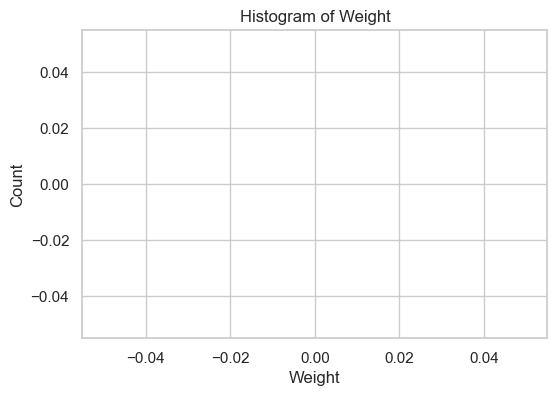

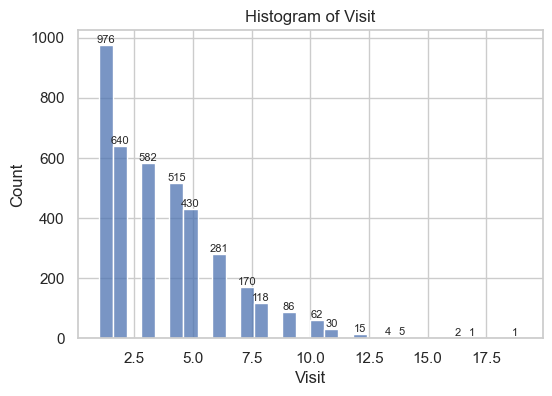

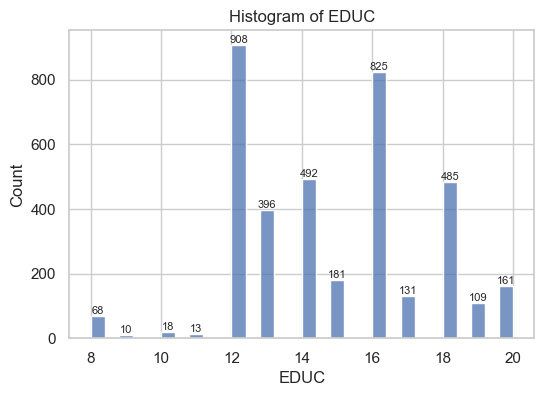

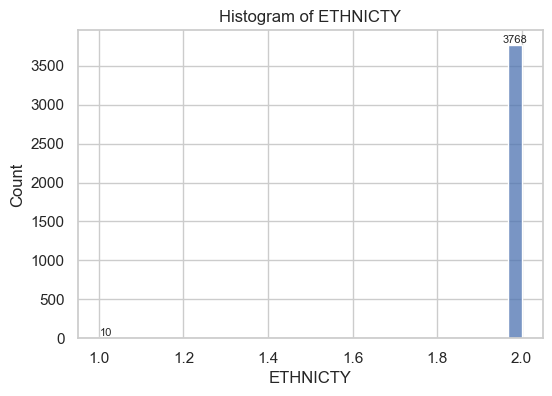

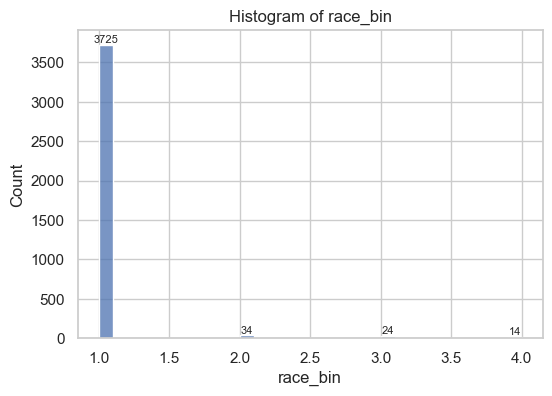

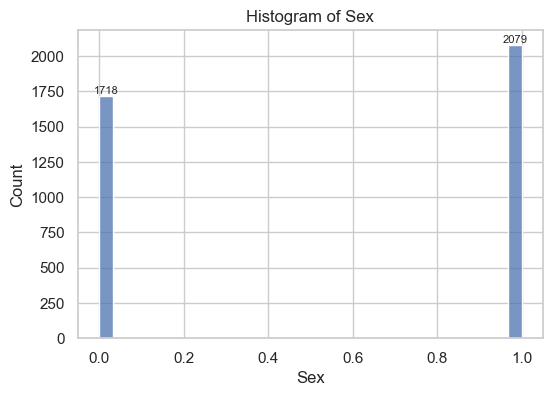

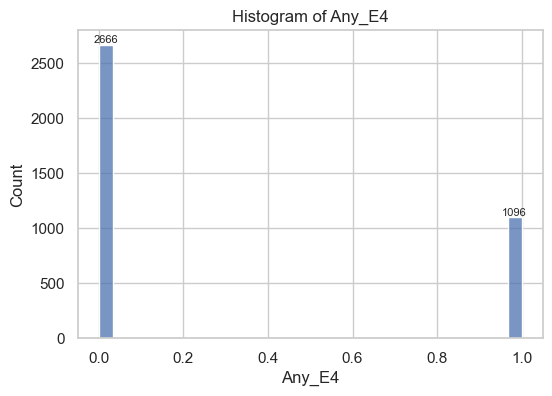

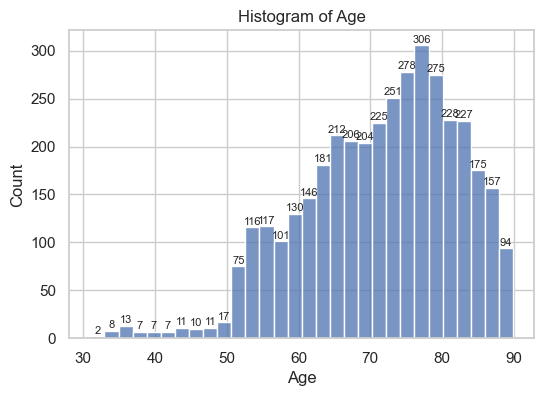

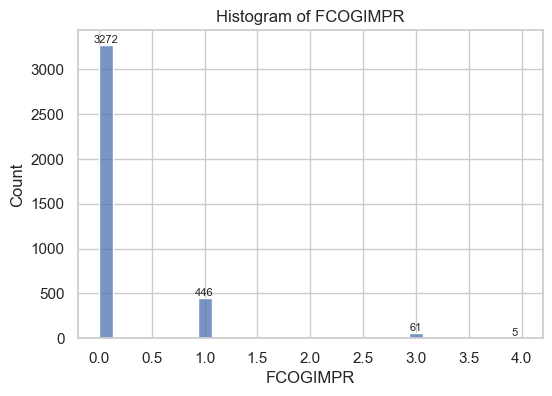

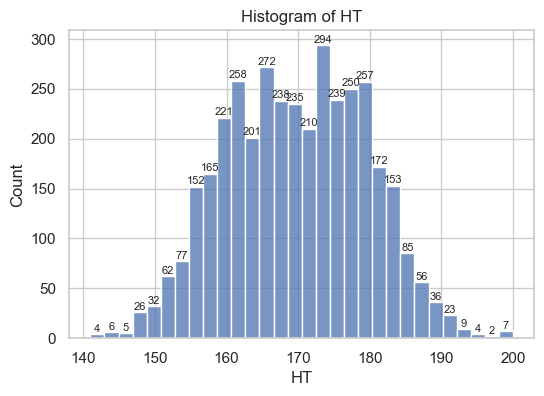

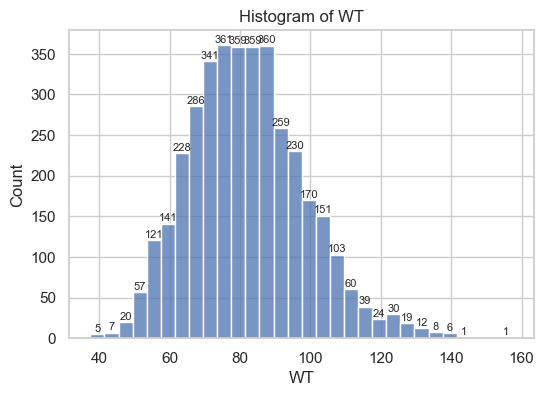

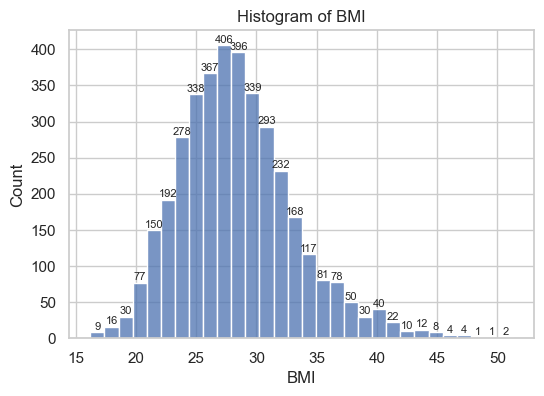

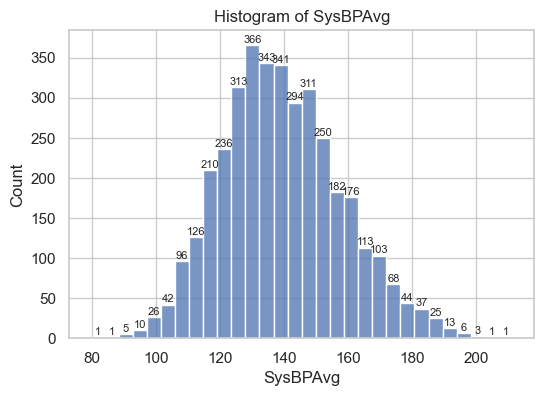

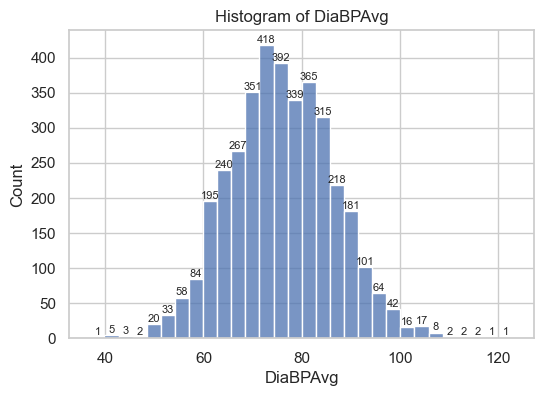

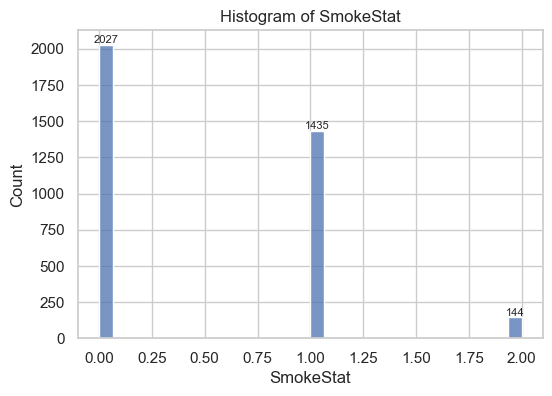

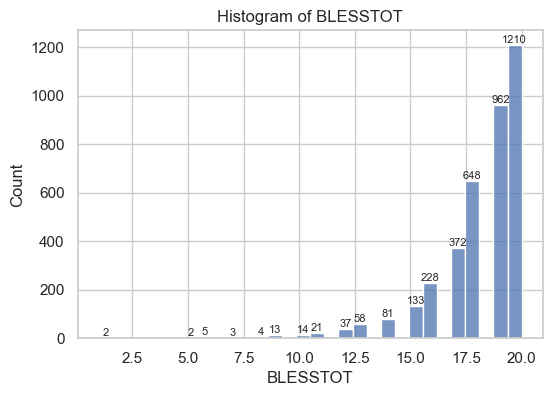

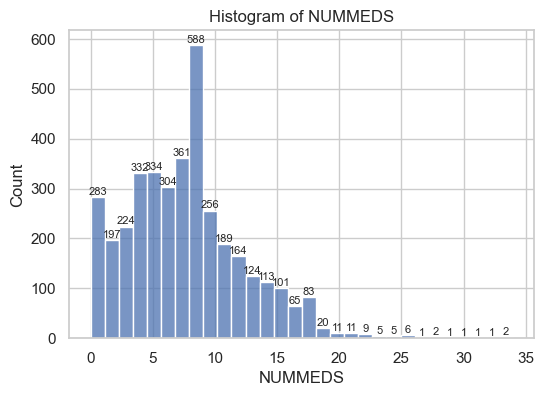

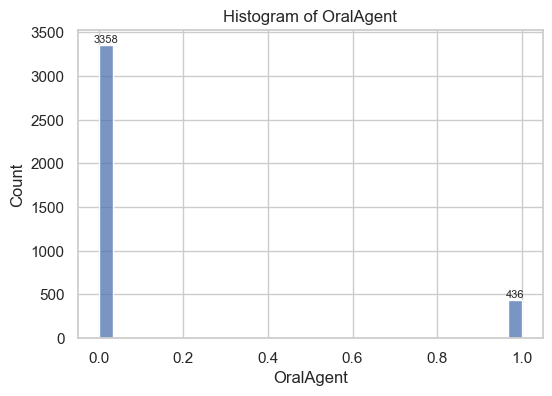

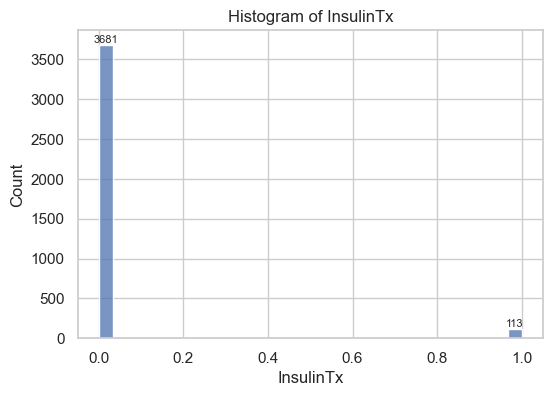

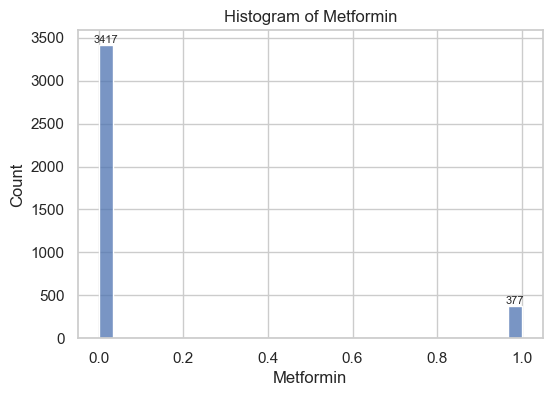

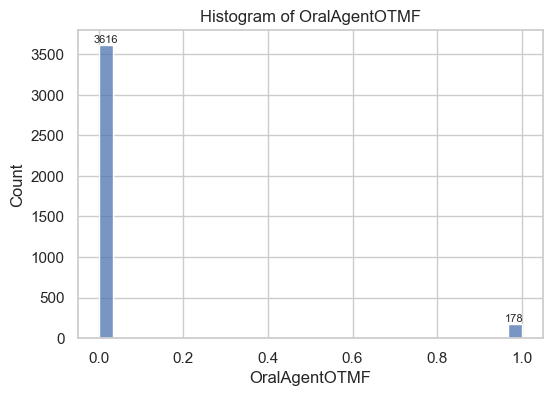

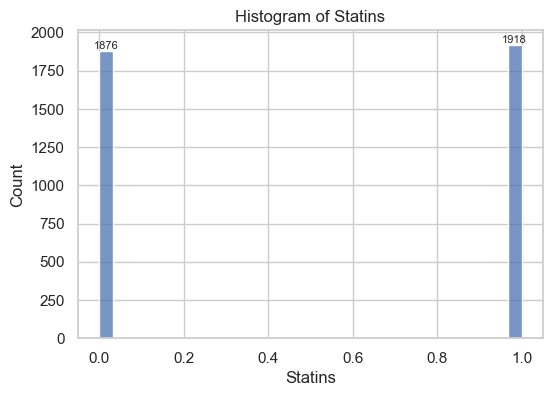

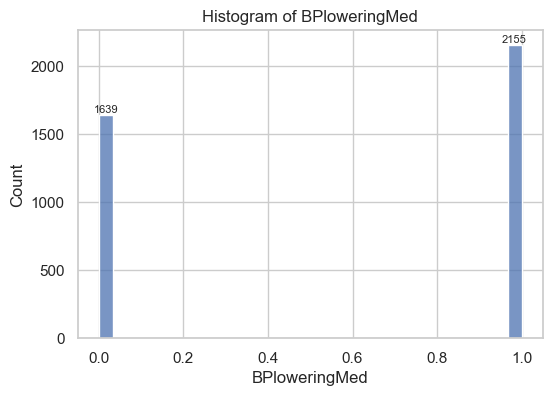

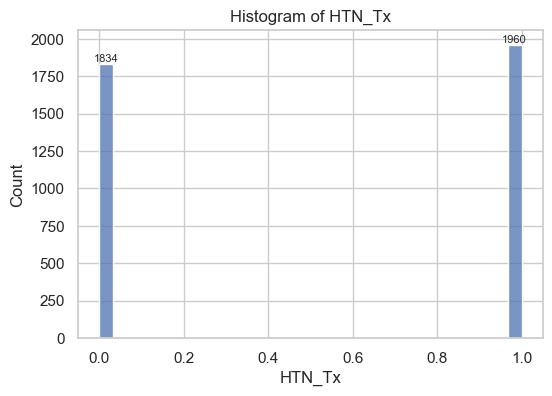

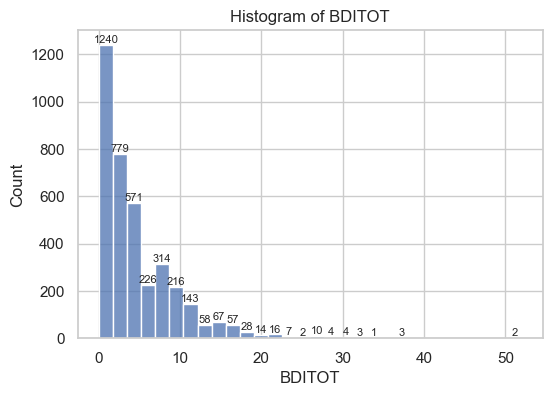

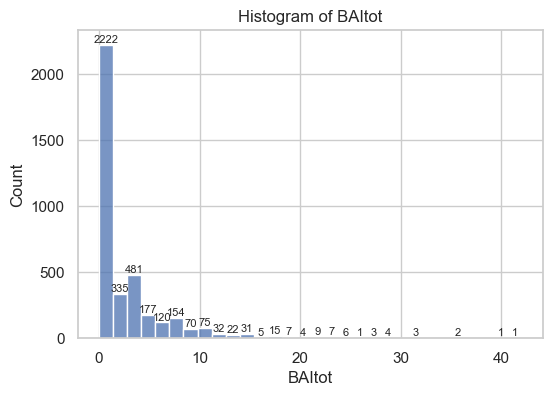

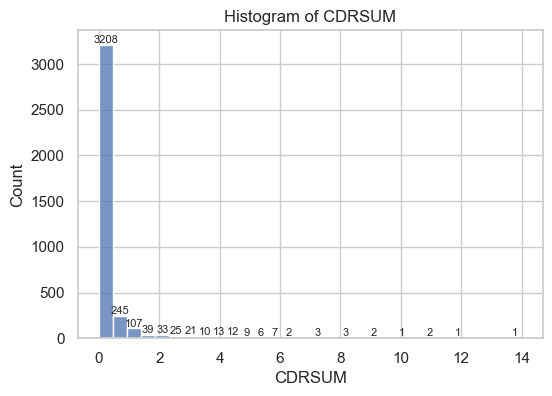

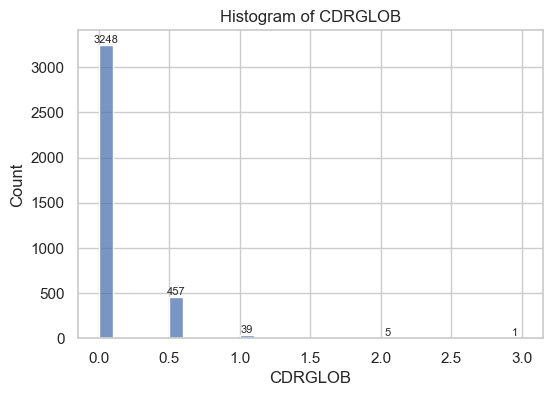

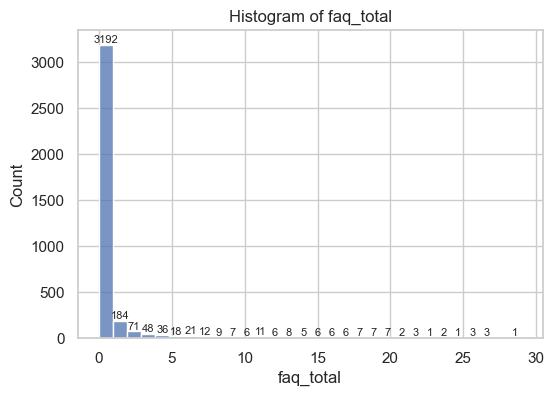

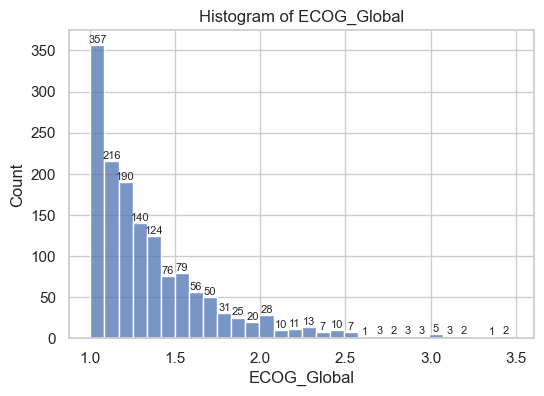

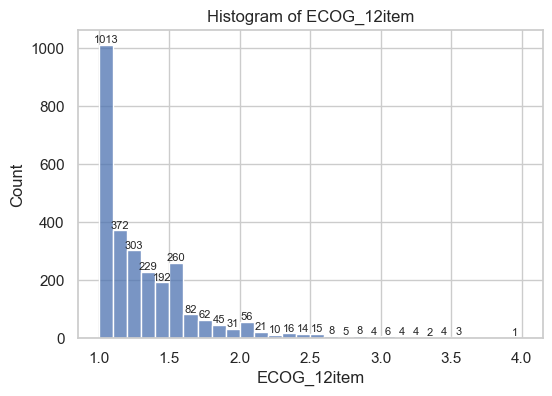

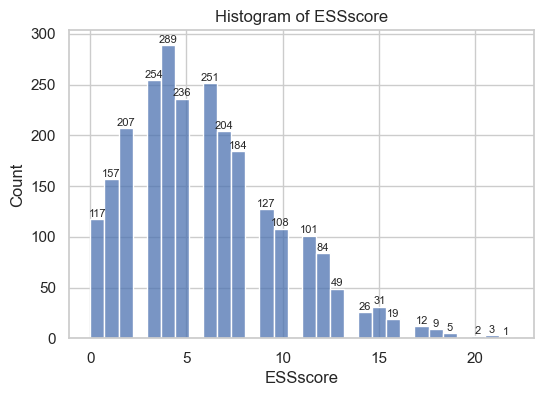

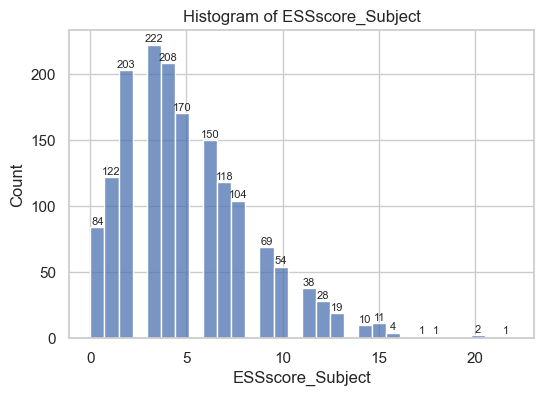

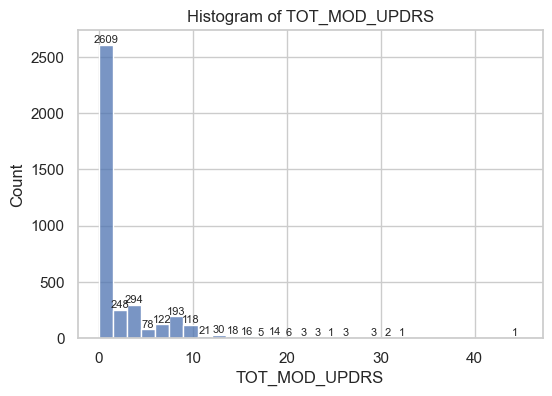

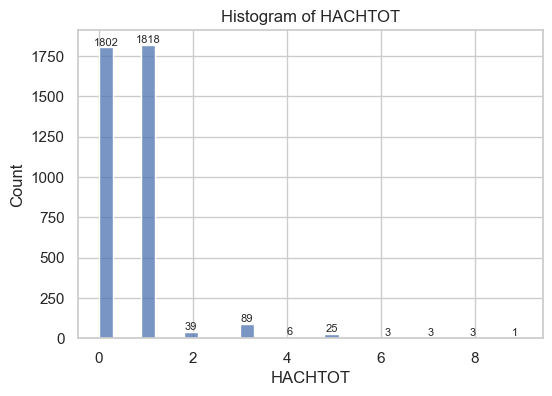

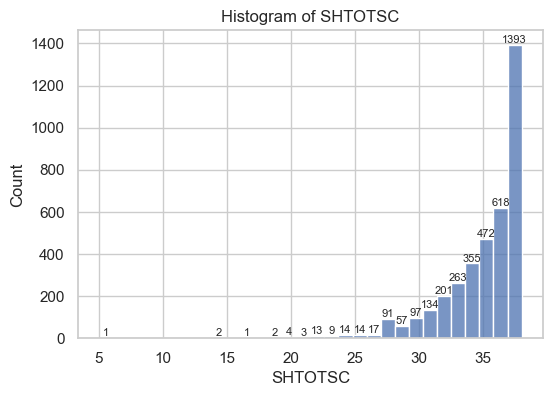

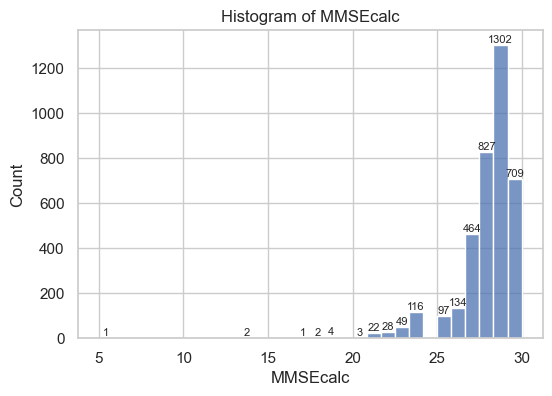

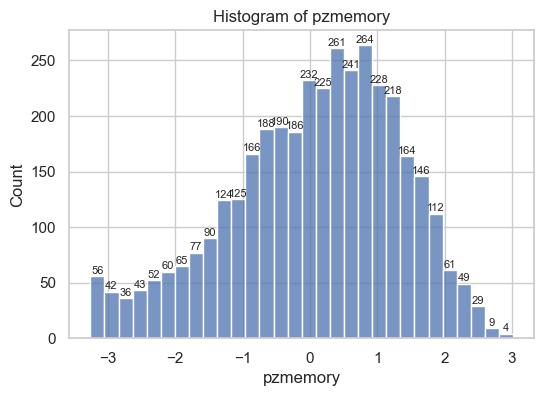

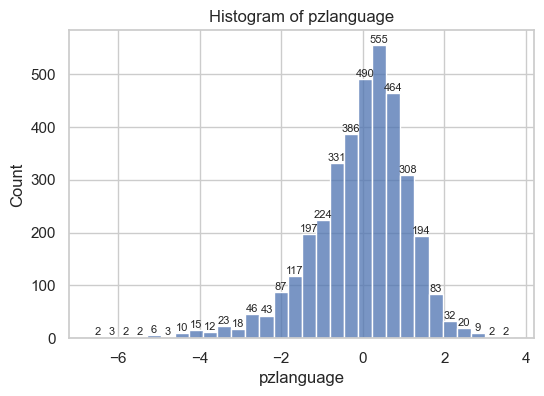

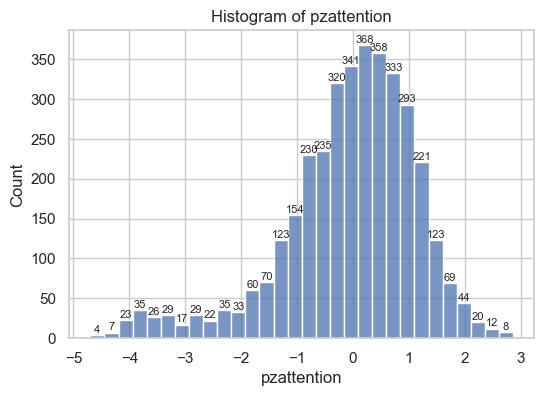

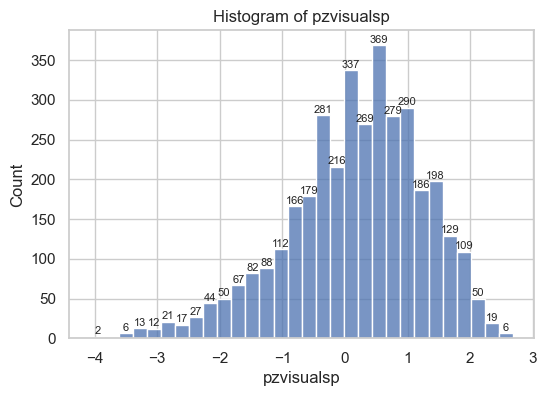

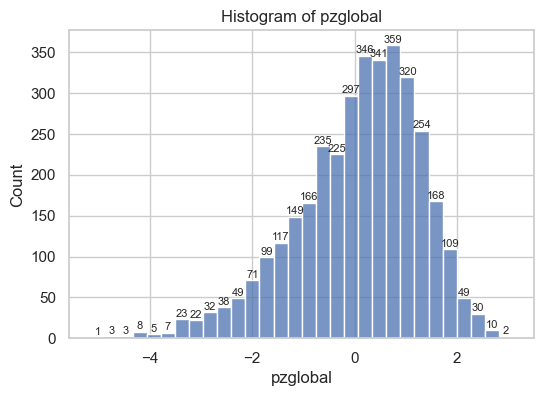

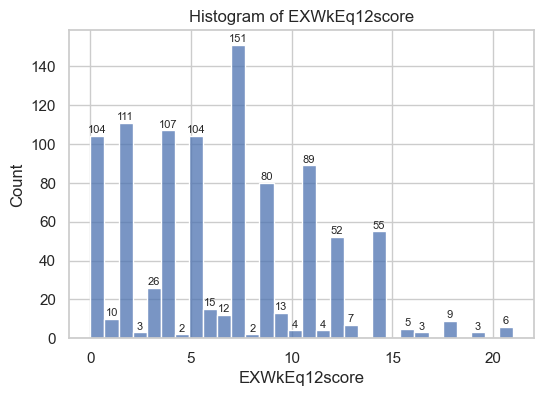

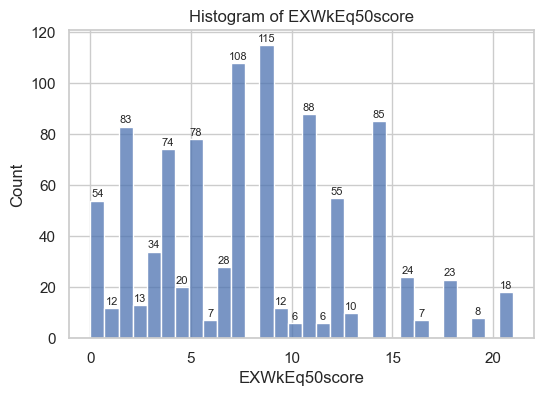

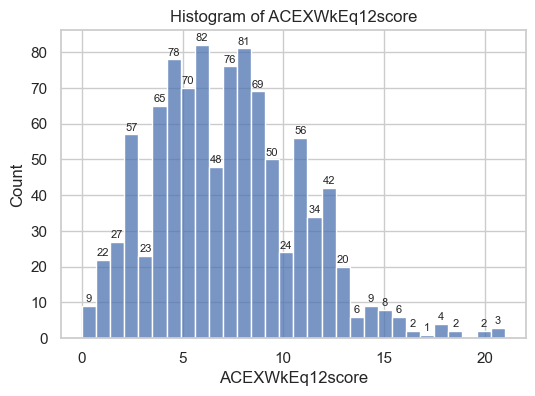

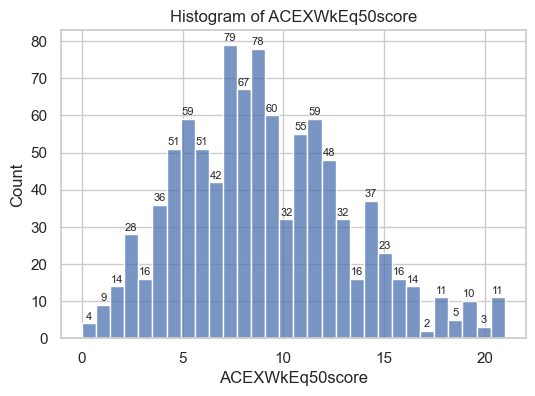

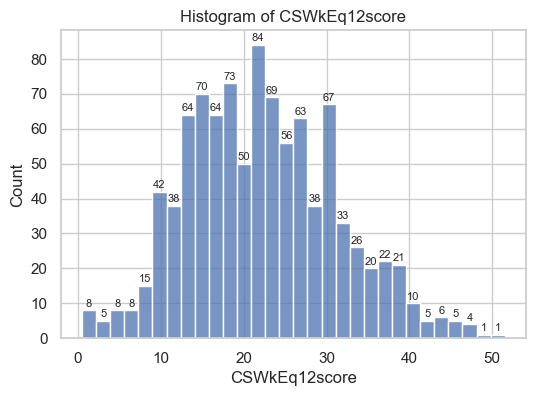

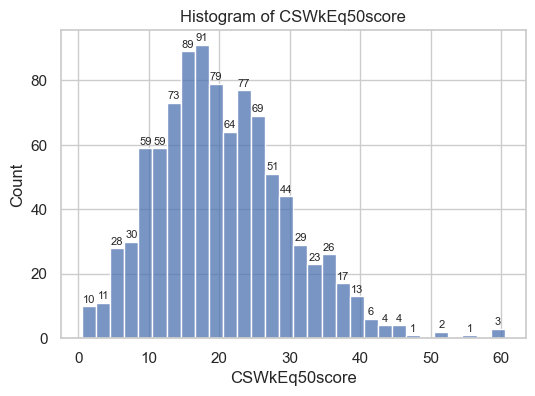

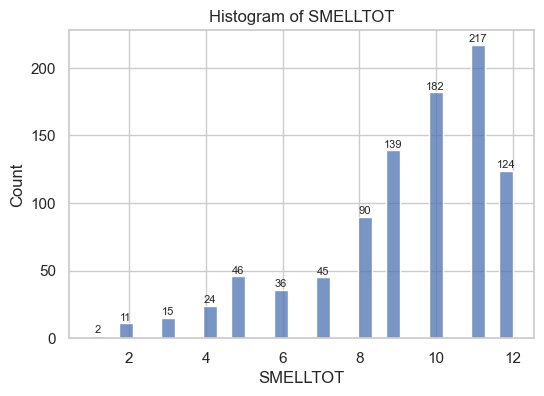

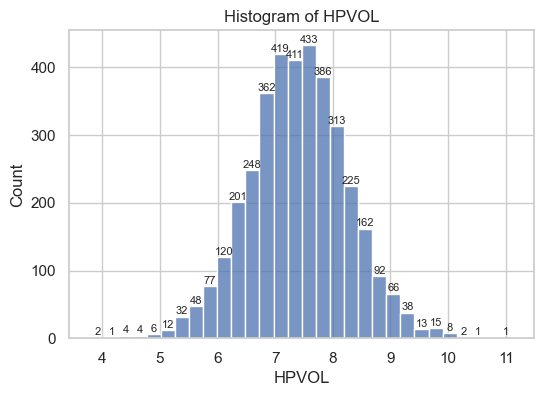

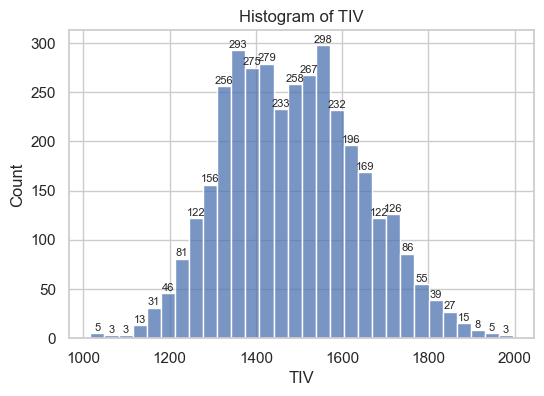

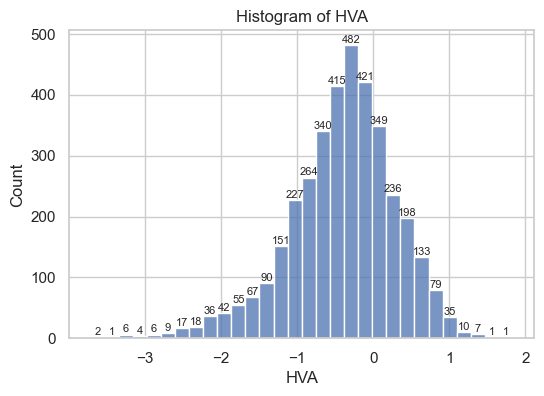

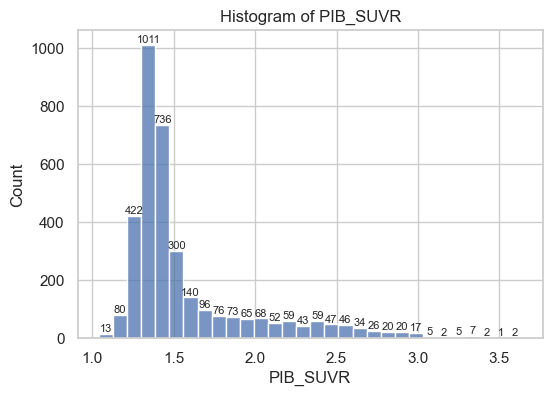

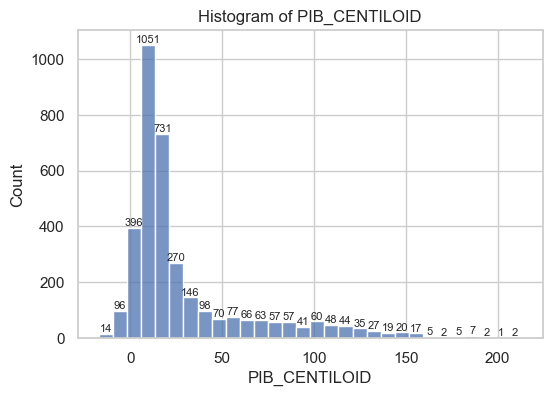

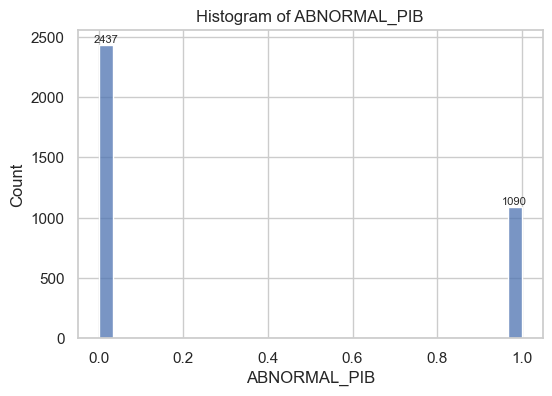

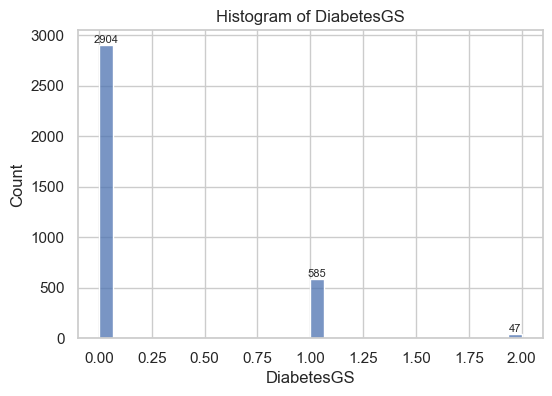

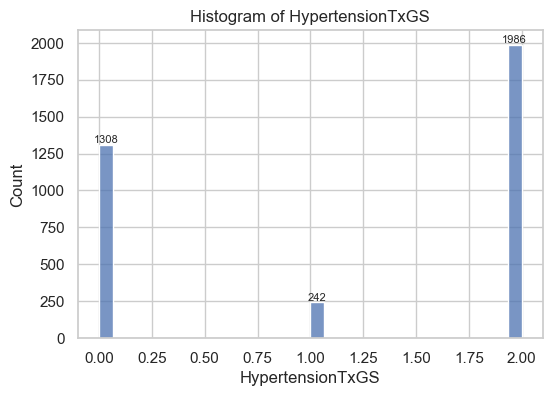

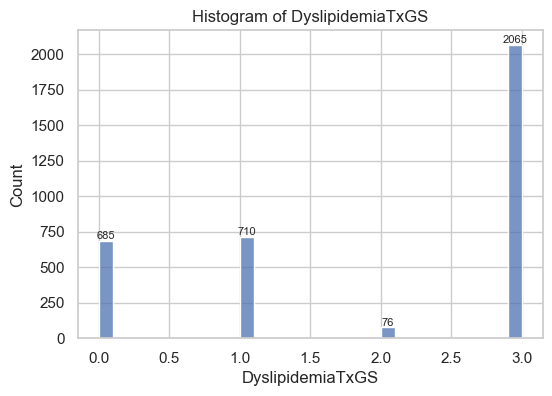

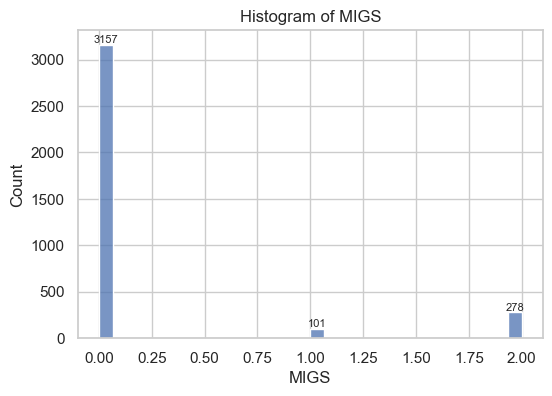

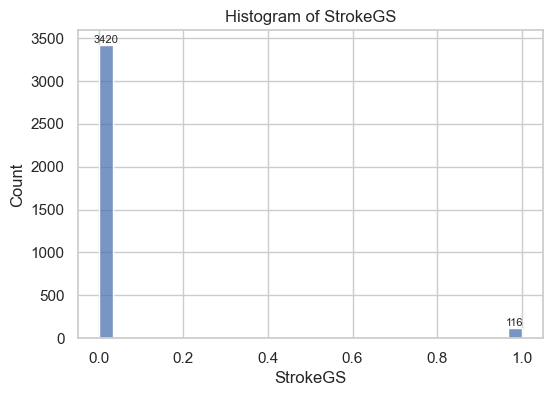

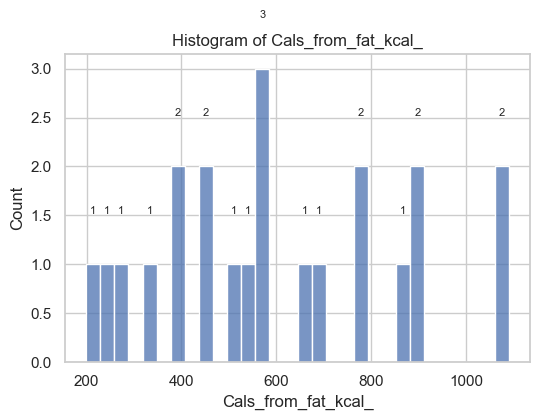

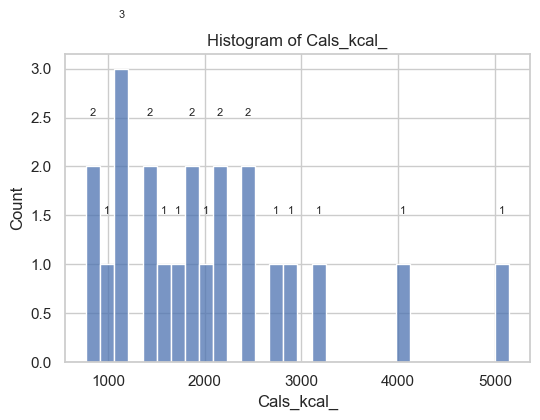

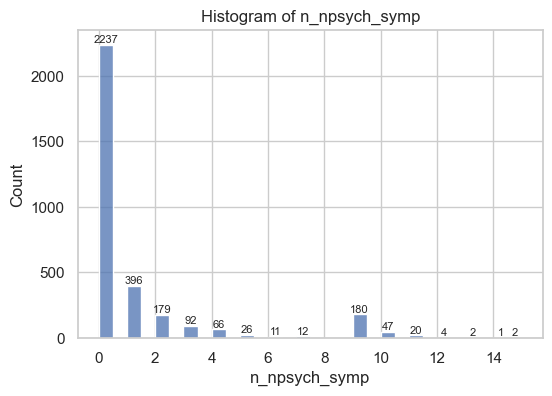

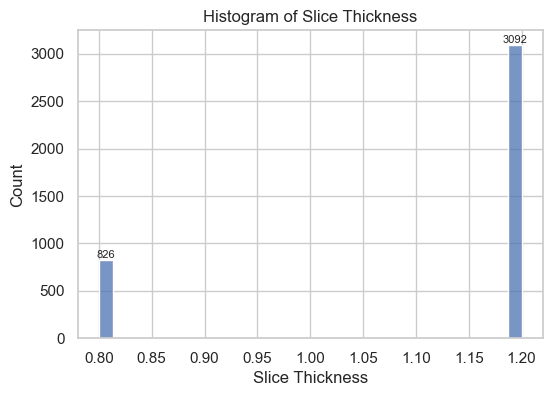

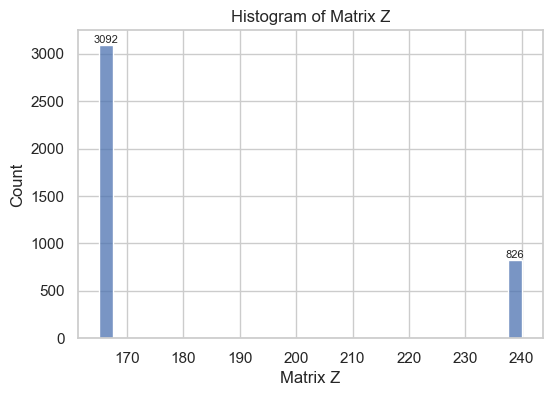

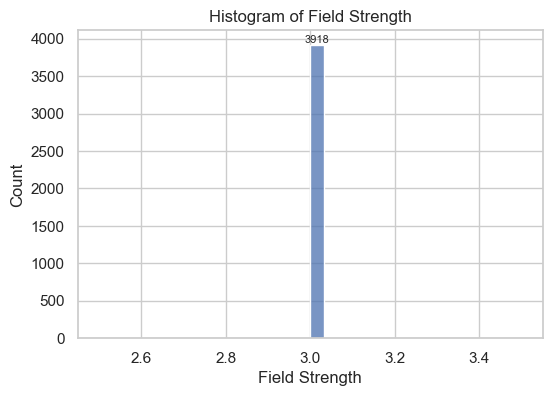

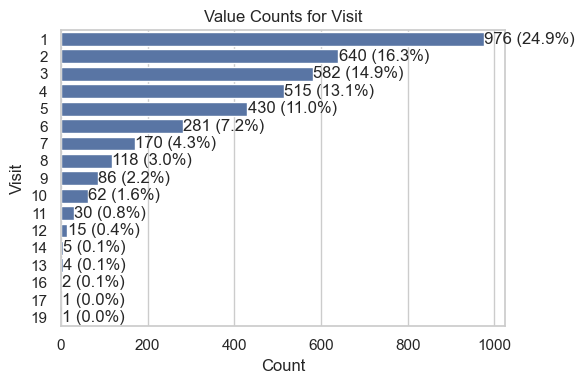

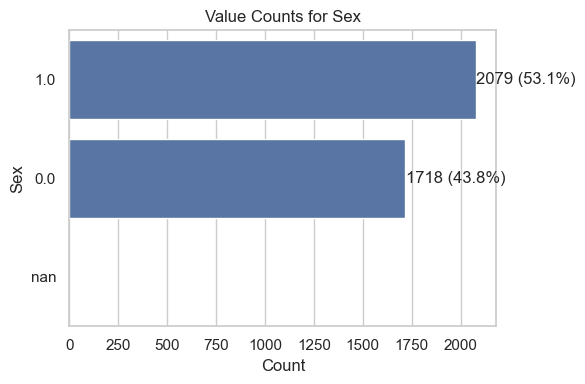

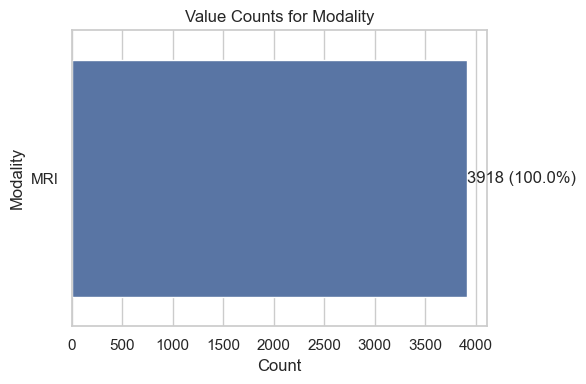

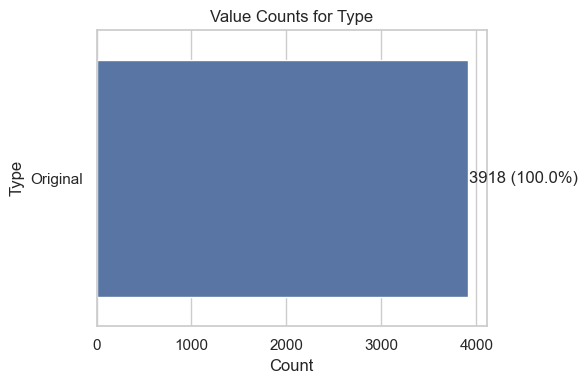

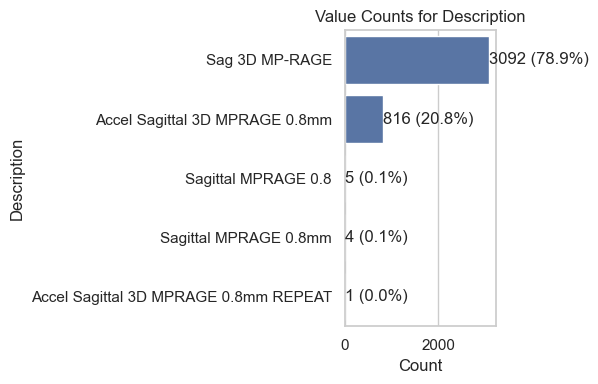

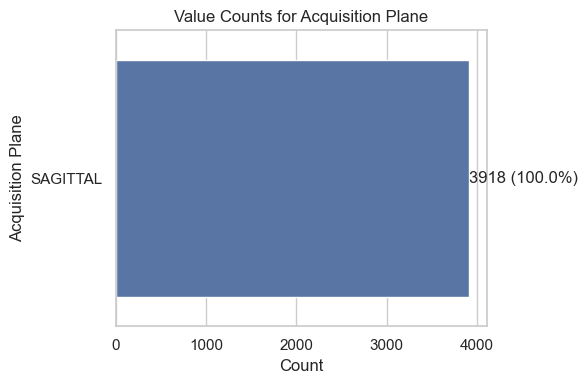

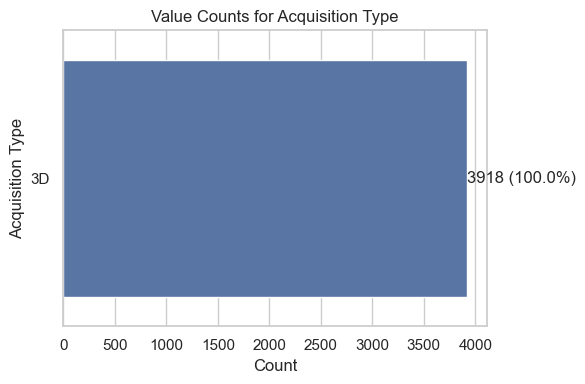

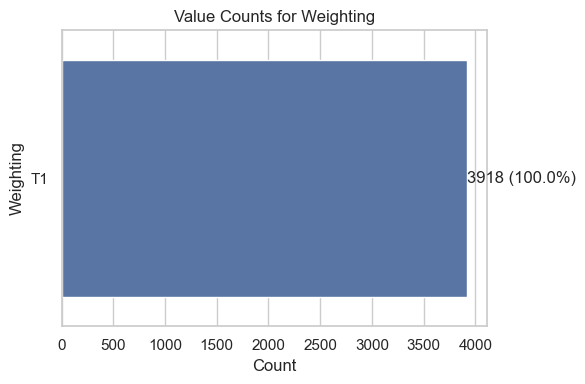

In [7]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

# -------------------------------
# Numeric Columns Histograms
# -------------------------------
for col in numeric_cols:
    plt.figure(figsize=(6, 4))

    # Plot histogram
    ax = sns.histplot(
        df[col].dropna(), bins=30, kde=False
    )  # disable KDE for counts clarity

    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    # Annotate counts on top of each bin
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # only annotate non-empty bins
            ax.text(
                patch.get_x() + patch.get_width() / 2,  # center of bin
                height + 0.5,  # slightly above the bar
                int(height),  # show integer count
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.show()

# -------------------------------
# Categorical Columns Bar Plots
# -------------------------------
categorical_cols = [
    "Visit",
    "Sex",
    "Research Group",
    "Modality",
    "Type",
    "Structure",
    "Laterality",
    "Image Type",
    "Registration",
    "Description",
    "Tissue",
    # Imaging Protocol–derived categorical columns
    "Acquisition Plane",
    "Acquisition Type",
    # "Manufacturer",
    # "Mfg Model",
    "Weighting",
]

categorical_cols = [col for col in categorical_cols if col in df.columns]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))

    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    order = counts.index

    ax = sns.countplot(y=col, data=df, order=order)

    # Add count + percentage labels
    for p, category in zip(ax.patches, order):
        count = counts[category]
        percent = 100 * count / total

        ax.text(
            p.get_width() + 0.5,
            p.get_y() + p.get_height() / 2,
            f"{count} ({percent:.1f}%)",
            va="center",
        )

    plt.title(f"Value Counts for {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


# Study dates

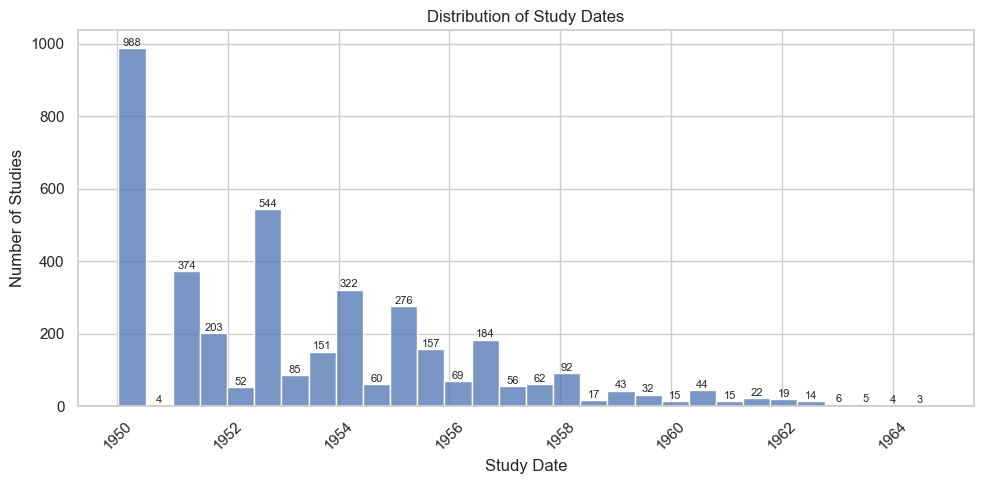

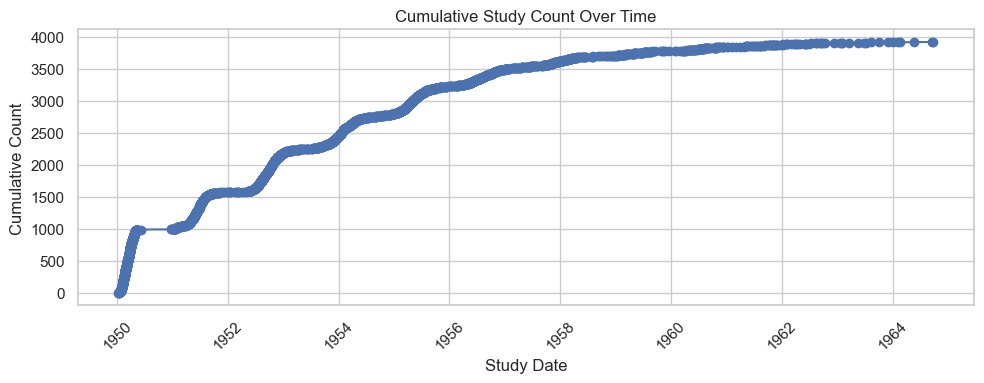

In [8]:
# -------------------------------
# Study Date Distribution
# -------------------------------


plt.figure(figsize=(10, 5))

# Histogram of study dates
ax = sns.histplot(df["Study Date"].dropna(), bins=30, kde=False)

plt.title("Distribution of Study Dates")
plt.xlabel("Study Date")
plt.ylabel("Number of Studies")

# Annotate counts on top of each bin
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.5,
            int(height),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# cumulative study count over time
plt.figure(figsize=(10, 4))
df_sorted = df.sort_values("Study Date")
df_sorted["Cumulative Count"] = range(1, len(df_sorted) + 1)
plt.plot(
    df_sorted["Study Date"], df_sorted["Cumulative Count"], marker="o", linestyle="-"
)
plt.title("Cumulative Study Count Over Time")
plt.xlabel("Study Date")
plt.ylabel("Cumulative Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Scans per session / coverage

Does a subject have more than one scan at a given visit?

How often does this happen?

In [9]:
df["Visit"] = df["Visit"].astype(str)

# scans per subject per visit
scans_per_subject_visit = (
    df.groupby(["Subject ID", "Visit"], observed=True)
    .size()
    .reset_index(name="n_scans")
)
# Keep only rows with at least 1 scan
scans_per_subject_visit = scans_per_subject_visit[
    scans_per_subject_visit["n_scans"] > 0
].copy()
# print(scans_per_subject_visit.head())
# print(scans_per_subject_visit["n_scans"].min())  # should now be >= 1


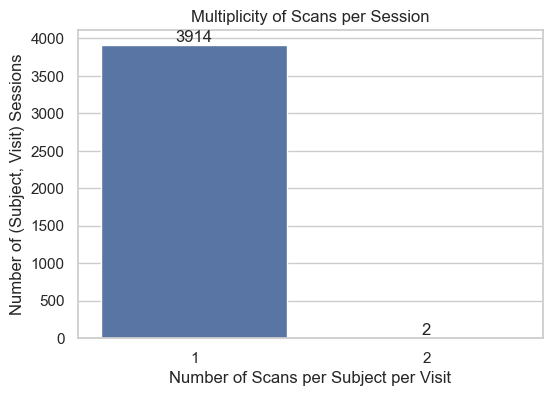

In [10]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="n_scans",
    data=scans_per_subject_visit,
    order=sorted(scans_per_subject_visit["n_scans"].unique()),
)

plt.xlabel("Number of Scans per Subject per Visit")
plt.ylabel("Number of (Subject, Visit) Sessions")
plt.title("Multiplicity of Scans per Session")

# Annotate counts on top of bars
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.show()


# Longitudinal analysis - for filtered subset

In [11]:
df["Visit"].unique()

array(['4', '1', '3', '5', '9', '10', '11', '2', '6', '8', '7', '12',
       '14', '16', '17', '19', '13'], dtype=object)

In [12]:
# Convert Visit to numeric
df["Visit_Num"] = pd.to_numeric(df["Visit"], errors="coerce")

# Sanity check
print(df["Visit_Num"].isna().sum())  # should be 0

# Scheduled visits are simply the numeric visit numbers
scheduled_visits = sorted(df["Visit_Num"].dropna().unique())

print("Scheduled Visits:", scheduled_visits)


scheduled_df = df.copy()

visits_per_subject = (
    scheduled_df.groupby("Subject ID", observed=True)["Visit_Num"]
    .nunique()
    .sort_values(ascending=False)
)

# Summary
summary_stats = visits_per_subject.describe()
print("Longitudinal Coverage per Subject:")
display(summary_stats)


0
Scheduled Visits: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(19)]
Longitudinal Coverage per Subject:


count    2121.000000
mean        1.846299
std         1.058633
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: Visit_Num, dtype: float64

In [13]:
df["Visit_Num"].unique()

array([ 4,  1,  3,  5,  9, 10, 11,  2,  6,  8,  7, 12, 14, 16, 17, 19, 13])

/tmp/ipykernel_1186540/2482556886.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")


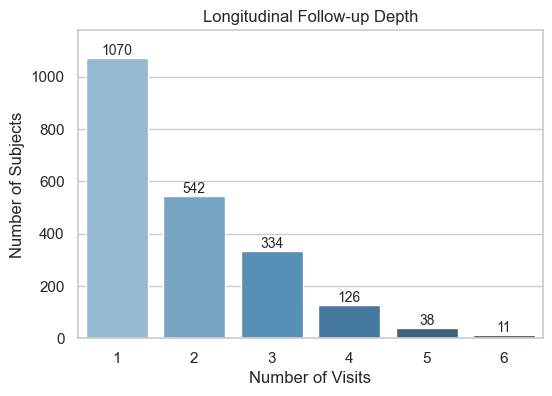

In [14]:
# Count how many subjects have N visits -- How many dropouts, How many fully followed subjects, wether dataset is shallow or deep
visit_counts = visits_per_subject.value_counts().sort_index()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")

# Annotate bars
for i, v in enumerate(visit_counts.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=10)

plt.xlabel("Number of Visits")
plt.ylabel("Number of Subjects")
plt.title("Longitudinal Follow-up Depth")
plt.ylim(0, visit_counts.values.max() * 1.1)
plt.show()


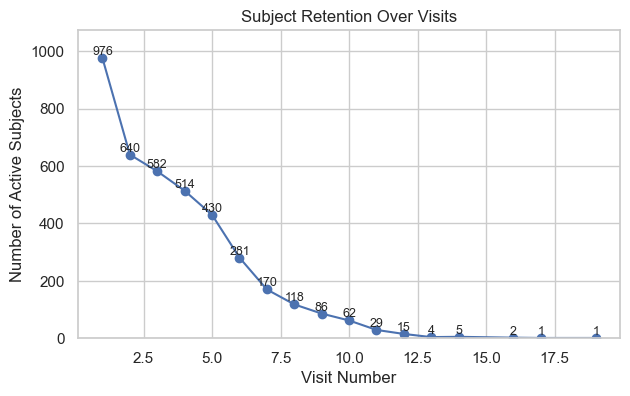

In [15]:
# how many subjects remain at each visit -- Where dropout occurs, Which visits are well populated
retention = (
    scheduled_df.groupby("Visit_Num", observed=True)["Subject ID"]
    .nunique()
    .sort_index()
)

plt.figure(figsize=(7, 4))
plt.plot(retention.index, retention.values, marker="o")

for x, y in zip(retention.index, retention.values):
    plt.text(x, y + 0.5, str(y), ha="center", va="bottom", fontsize=9)

plt.xlabel("Visit Number")
plt.ylabel("Number of Active Subjects")
plt.title("Subject Retention Over Visits")
plt.grid(True)
plt.ylim(0, retention.max() * 1.1)
plt.show()


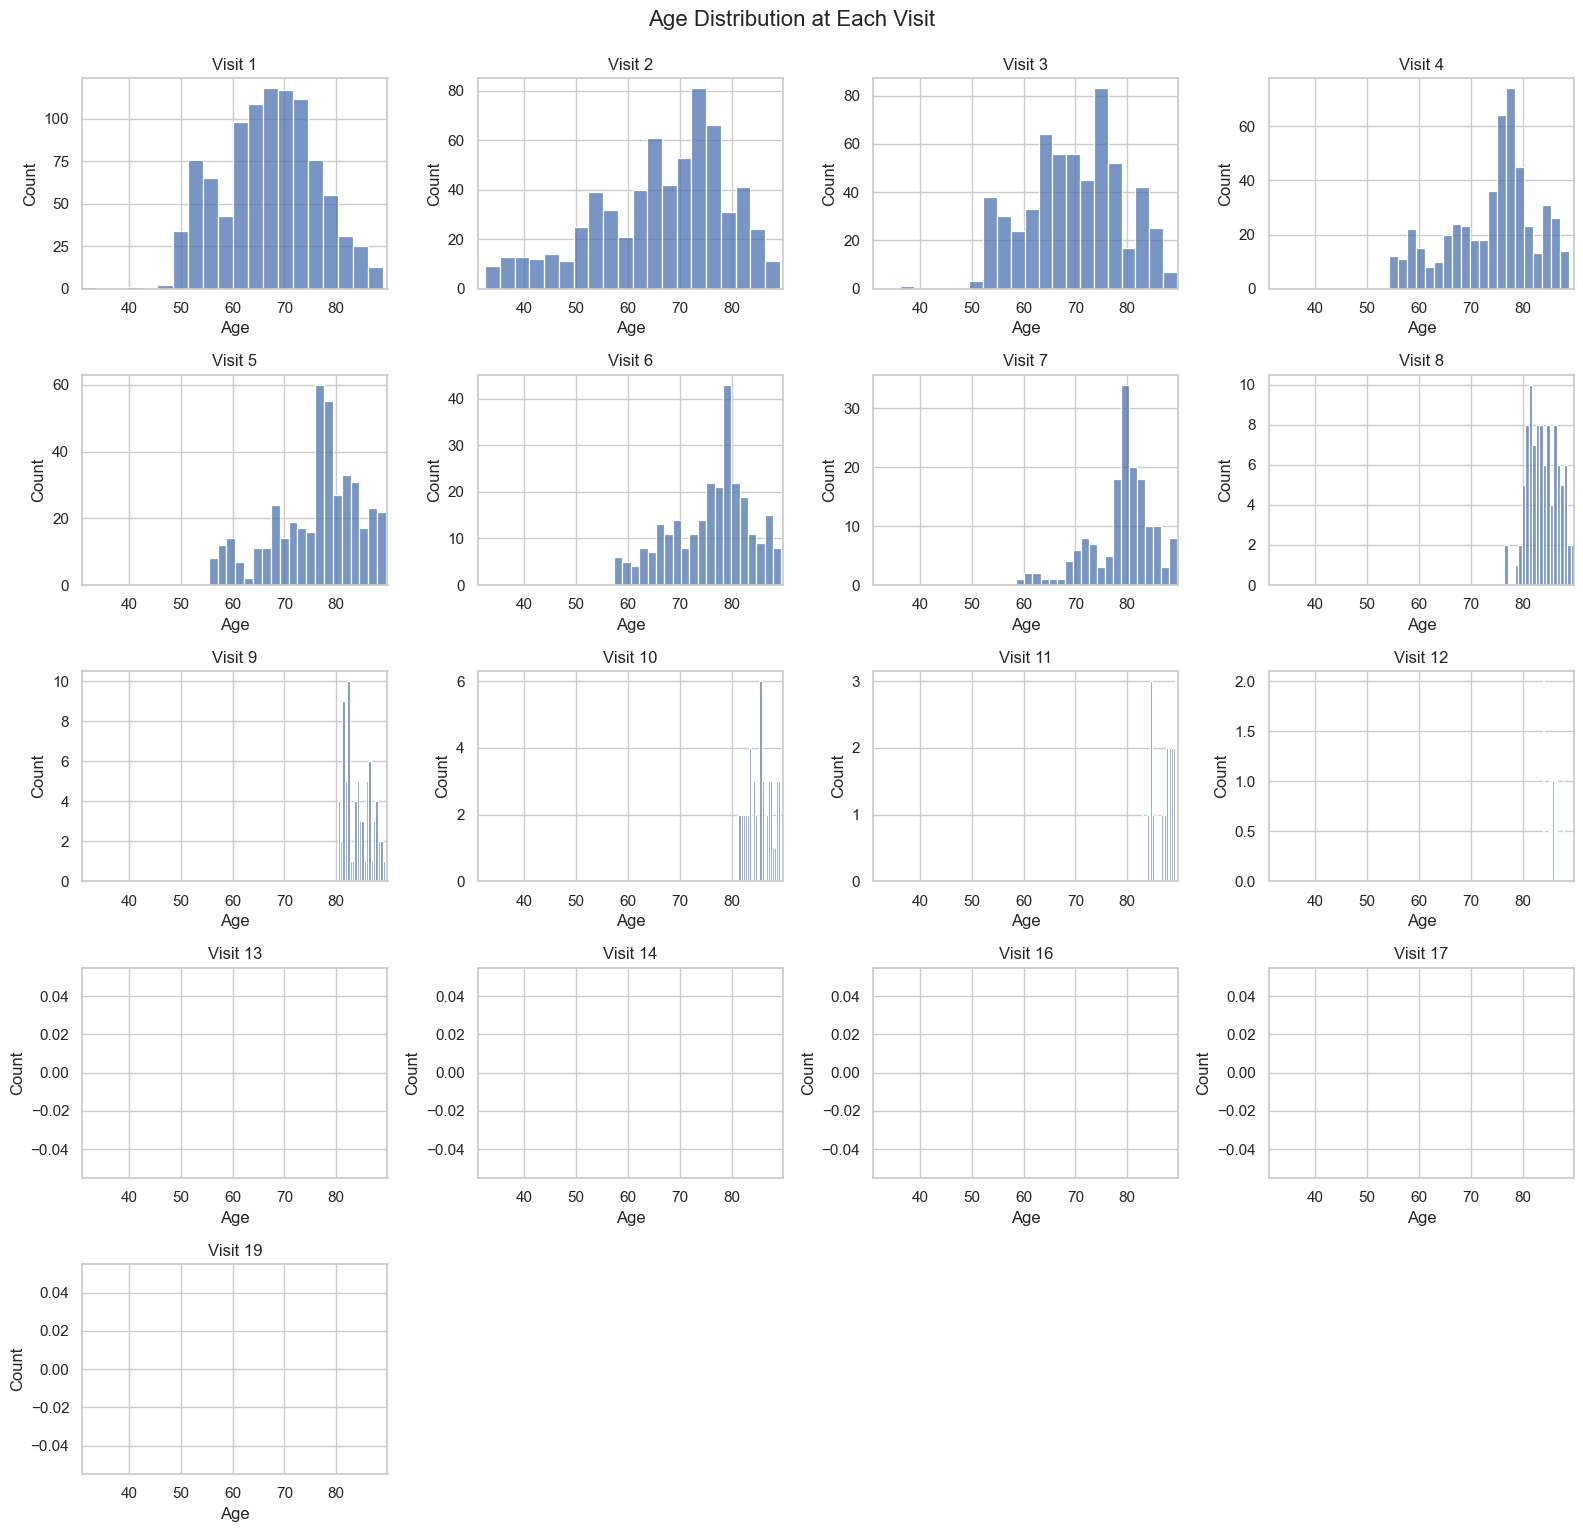

In [16]:
# Ensure Visit is treated as a category so we know the set of visits
df["Visit_Str"] = df["Visit"].astype(str)

# Sort visit labels numerically (if numeric)
try:
    sorted_visits = sorted(df["Visit_Str"].unique(), key=lambda x: int(x))
except ValueError:
    sorted_visits = sorted(df["Visit_Str"].unique())

# How many columns/rows for the figure grid
n_visits = len(sorted_visits)
n_cols = 4  # change if you want wider or narrower layout
n_rows = (n_visits + n_cols - 1) // n_cols

plt.figure(figsize=(4 * n_cols, 3 * n_rows))

for i, visit_label in enumerate(sorted_visits):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    visit_df = df[df["Visit_Str"] == visit_label]

    sns.histplot(visit_df["Age"].dropna(), bins=20, kde=False, ax=ax)
    ax.set_title(f"Visit {visit_label}")
    ax.set_xlabel("Age")
    ax.set_ylabel("Count")
    ax.set_xlim(df["Age"].min(), df["Age"].max())

plt.tight_layout()
plt.suptitle("Age Distribution at Each Visit", y=1.02, fontsize=16)
plt.show()